In [138]:
%pip install imutils
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


In [139]:
import cv2
import argparse
import ntpath
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import imutils
from imutils.video import WebcamVideoStream

In [140]:
def readFiles(path):
    img = cv2.imread(path)
    return img

In [141]:
detectors = {
    "eye": os.path.sep.join([ntpath.dirname(cv2.__file__), 'data', 'haarcascade_eye.xml']),
    "face": os.path.sep.join([ntpath.dirname(cv2.__file__), 'data', 'haarcascade_frontalface_default.xml'])
}
def detect(gray, part="face"):
    
    detector = cv2.CascadeClassifier(detectors[part])
    rects = detector.detectMultiScale(gray, scaleFactor=2, minNeighbors=5, minSize=(15, 15),
                                      flags=cv2.CASCADE_SCALE_IMAGE)
    return rects

In [142]:
def Recording():
    
    # open webcam
    vs = WebcamVideoStream().start()
    start = time.time()
    fps = vs.stream.get(cv2.CAP_PROP_FPS)
    print("Frames per second using cv2.CAP_PROP_FPS : {0}".format(fps))

    while True:
        # turn to gray image to detect face
        frame = vs.read()
        img = frame.copy()
        img = imutils.resize(img, width=300)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # 呼叫偵測函數，取得結果
        rects = detect(gray)
        
        # 繪出偵測結果 (記得將偵測的座標轉回原本的frame大小)
        ratio = frame.shape[1] / img.shape[1]
        for rect in rects:
            rect = rect * ratio
            (x, y, w, h) = rect.astype("int")
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # 標示FPS
        end = time.time()
        text = f"FPS: {str(int(1 / (end - start)))}"
        cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        start = end

        # 顯示影像
        cv2.imshow("Frame", frame)

        # 判斷是否案下"q"；跳離迴圈
        key = cv2.waitKey(1) & 0xff
        if key == ord('q'):
            break

    #  清除畫面與結束WebCam
    cv2.destroyAllWindows()
    vs.stop()




In [143]:
def img2Gray(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img, gray

In [144]:
def showImage(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [155]:
def GetFaceMask(img):
    img, Gimg = img2Gray(img)
    rects = detect(Gimg) # return multi-face
    
    # Face mask, cut out of face region
    Facemask = np.zeros_like(img)
    (y, x, w, h) = rects[0].astype("int")
    Facemask = cv2.rectangle(Facemask, (y,x), (y + w, x + h), (255,255,255), -1)
    
    return Facemask

In [156]:
def skinDetection(img):
    img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    HSV_mask = cv2.inRange(img_HSV, (0, 15, 0), (17,170,255)) 
    HSV_mask = cv2.morphologyEx(HSV_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

    #converting from gbr to YCbCr color space
    img_YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    #skin color range for hsv color space 
    YCrCb_mask = cv2.inRange(img_YCrCb, (0, 135, 85), (255,180,135)) 
    YCrCb_mask = cv2.morphologyEx(YCrCb_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

    #merge skin detection (YCbCr and hsv)
    global_mask=cv2.bitwise_and(YCrCb_mask,HSV_mask)
    global_mask=cv2.medianBlur(global_mask,3)
    global_mask = cv2.morphologyEx(global_mask, cv2.MORPH_OPEN, np.ones((4,4), np.uint8))


    HSV_result = cv2.bitwise_not(HSV_mask)
    YCrCb_result = cv2.bitwise_not(YCrCb_mask)
    global_result=cv2.bitwise_not(global_mask)
    
    return global_result

In [157]:
def GetSkinMask(img):
    # find skin region, 0 is skin, otherwise is 1
    SkinImage = skinDetection(img)
    skinMask = np.zeros_like(img)
    skinMask[SkinImage[:,:] == 0] = (255,255,255)
    skinMask[SkinImage[:,:] == 1] = (0, 0, 0)
    
    return 


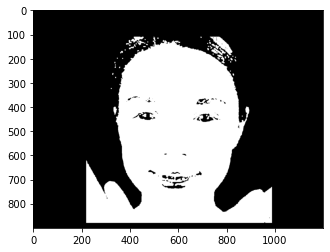

In [162]:
if __name__ == "__main__":
    
    #Read Image
    img = cv2.imread('data/acne_face.jpeg')

    skinMask = GetSkinMask(img)
    faceMask = GetFaceMask(img)
    
    
    # combine two mask
    Face_Skin_Mask = cv2.bitwise_and(skinMask, mask)
    cv2.imwrite('MaskFaceSkin.png', Face_Skin_Mask)
    showImage(Face_Skin_Mask)


    

In [103]:
black

(array([396, 399, 434, 435, 438, 440, 440, 441]),
 array([866, 864, 470, 470, 710, 705, 706, 705]))